In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans

import os

In [2]:
def extract_lab_features(image):
    # Identify black pixels in the original image (RGB values are all zero)
    black_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) == 0
    # Create an inverse mask for non-black pixels
    non_black_mask = ~black_mask

    # Convert the image from BGR to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into separate channels
    L_channel, A_channel, B_channel = cv2.split(lab_image)

    # Apply the non-black mask to each channel
    L_non_black = L_channel[non_black_mask]
    A_non_black = A_channel[non_black_mask]
    B_non_black = B_channel[non_black_mask]

    # Check if there are any non-black pixels
    if L_non_black.size == 0:
        # If all pixels are black, set the mean LAB values to zero or handle as needed
        l_mean = 0
        a_mean = 0
        b_mean = 0
    else:
        # Compute the mean L, A, B values for non-black pixels
        l_mean = np.mean(L_non_black)
        a_mean = np.mean(A_non_black)
        b_mean = np.mean(B_non_black)

    return l_mean, a_mean, b_mean

In [3]:
filenames = []
l_values = []
a_values = []
b_values = []

In [4]:
base_image_path = '../Static Analysis/Data/extracted'
images = os.listdir(base_image_path)

In [5]:
for image_file in tqdm(images, desc="Parsing images"):
    # Check if the file is an image
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Construct the full image path
        full_image_path = os.path.join(base_image_path, image_file)
        # Read the image
        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Error: Unable to read image at {full_image_path}")
            continue
        
        # Extract LAB features
        l_mean, a_mean, b_mean = extract_lab_features(image)
        
        # Append the data to the lists
        filenames.append(full_image_path)
        l_values.append(l_mean)
        a_values.append(a_mean)
        b_values.append(b_mean)


Parsing images: 100%|██████████| 894/894 [00:04<00:00, 219.72it/s]


In [6]:
df = pd.DataFrame({
    'filename': filenames,
    'L': l_values,
    'A': a_values,
    'B': b_values
})

In [15]:
overall_L_mean = df['L'].mean()

In [7]:
X = df[['A', 'B']]
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
print(df)

                                              filename           L  \
0    ../Static Analysis/Data/extracted\test_visuali...  124.878502   
1    ../Static Analysis/Data/extracted\test_visuali...  109.148751   
2    ../Static Analysis/Data/extracted\test_visuali...  145.036914   
3    ../Static Analysis/Data/extracted\test_visuali...  128.130234   
4    ../Static Analysis/Data/extracted\test_visuali...  119.096429   
..                                                 ...         ...   
889  ../Static Analysis/Data/extracted\test_visuali...  105.544621   
890  ../Static Analysis/Data/extracted\test_visuali...  140.506959   
891  ../Static Analysis/Data/extracted\test_visuali...   93.217493   
892  ../Static Analysis/Data/extracted\test_visuali...   95.537642   
893  ../Static Analysis/Data/extracted\test_visuali...   75.425895   

              A           B  cluster  
0    148.661143  142.332591        0  
1    140.524669  135.339649        1  
2    139.571737  130.123355        1  
3  

c:\Users\ezrat\anaconda3\envs\Project\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


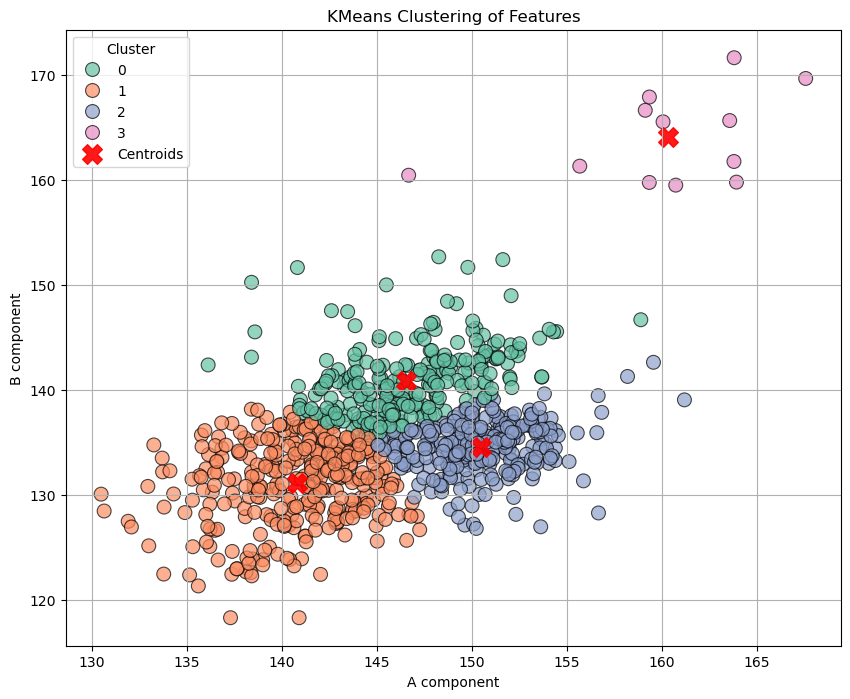

In [8]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='A',
    y='B',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='k',
    alpha=0.7
)

# Plot the cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    s=200,
    alpha=0.9,
    marker='X',
    label='Centroids'
)

# Customize the plot
plt.title('KMeans Clustering of Features')
plt.xlabel('A component')
plt.ylabel('B component')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

In [16]:
cluster_means = df.groupby('cluster')[['A', 'B']].mean().reset_index()

In [17]:
def lab_to_rgb(l, a, b):
    # Create a 1x1 LAB image
    lab_color = np.uint8([[[l, a, b]]])
    # Convert LAB to BGR
    bgr_color = cv2.cvtColor(lab_color, cv2.COLOR_LAB2BGR)
    # Convert BGR to RGB
    rgb_color = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2RGB)
    # Flatten the array
    rgb_color = rgb_color.flatten()
    return rgb_color

In [18]:
cluster_colors = []

for _, row in cluster_means.iterrows():
    l_mean = overall_L_mean
    a_mean = row['A']
    b_mean = row['B']
    rgb_color = lab_to_rgb(l_mean, a_mean, b_mean)
    cluster_colors.append(rgb_color)

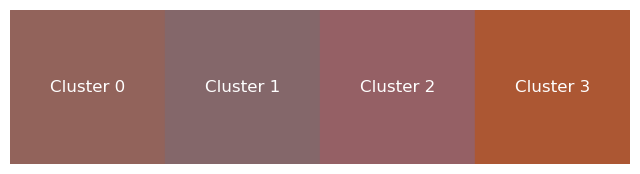

In [19]:
fig, ax = plt.subplots(figsize=(8, 2))

for i, rgb_color in enumerate(cluster_colors):
    # Normalize RGB values to [0,1] for matplotlib
    rgb_normalized = rgb_color / 255.0
    rect = plt.Rectangle((i, 0), 1, 1, color=rgb_normalized)
    ax.add_patch(rect)
    ax.text(i + 0.5, 0.5, f'Cluster {i}', va='center', ha='center', fontsize=12, color='white')

ax.set_xlim(0, len(cluster_colors))
ax.set_ylim(0, 1)
ax.axis('off')
plt.show()